# Solar Energy Adoption by County in the US

This project explores adoption of solar energy in the US.

## Business Understanding

The first aim is to examine the relationship between solar energy adoption and demographics. The specific variables analyzed, and the rationale for their selection, are:
- Per-capita income: is solar a luxury, installed mostly in high-income areas?
- Population density: is solar more prominent in urban areas, perhaps associated with a more progressive population, or in rural areas, where the conventional grid may be less reliable or self-reliance more important?
- Homeowner status: homeowners would have the ability to add solar panels that might be prohibited by renters' landlords or not an option in large multi-unit apartment buildings.

Understanding these relationships could be useful for targeting consumer solar marketing campaigns, or political campaigns supporting increased use of clean energy.

The second aim is to identify the areas with the largest and smallest growth (based on change in percentage of qualified roofs with installations) over time. 

This might give additional insight into which regions could be targeted for increased marketing of solar, or which might be more receptive to political initiatives promoting renewable energy.

## Data Understanding

For this analysis, we require data on solar installations (at multiple timepoints for the second aim), and on population demographics.

A search of publicly-available data on solar energy identified [Google Project Sunroof](https://www.google.com/get/sunroof). Their datasets include an estimate of the number of solar installations for various geographic units. Data for 2021 were available directly from the [site](https://www.google.com/get/sunroof/data-explorer/), while a 2017 dataset was found on [Kaggle](https://www.kaggle.com/jboysen/google-project-sunroof). This gives us data for two timepoints. 

Demographic data are available from the [US Census Bureau](https://data.census.gov/cedsci/). This site can be difficult to navigate if one is not sure exactly whih tables of data one wants. Fortunately, census data from 2017 which includes population and per-capita household income are available from [this Kaggle source](https://www.kaggle.com/muonneutrino/us-census-demographic-data). 

Data on home ownership from the 2019 American Community Survey are in table [DP04]((https://data.census.gov/cedsci/table?q=tenure&tid=ACSDP1Y2019.DP04&hidePreview=false).

Finally, land area data (to calculate population density) were found on [this Census bureau page](https://www.census.gov/library/publications/2011/compendia/usa-counties-2011.html#LND). 

For both sources, data are avialble for multiple geographic units:
- State
- County
- City
- Census tract
- Zip code

County-level data were selected to provide more granularity than state data, as well as (hopefully) some degree of homogeneity in demographics, governmental structure, and geography.  I chose to exclude city-level data as it would not include rural/unincorporated areas, and zip code and census tract  as they were likely to be too small to reveal discernible trends.  

#### Examining the data 

In [218]:
# import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import re

In [219]:
# read in the data
# Google project sunroof for 2017 & 2021
df_ps17 = pd.read_csv('projsunrf_cty_2017.csv')
df_ps21 = pd.read_csv('projsunrf_cty_2021.csv')

In [220]:
display(df_ps17.head())
display(df_ps21.head())
display('2017 entries: {}'.format(df_ps17.shape[0]))
display('2021 entries: {}'.format(df_ps21.shape[0]))

,region_name,state_name,lat_max,lat_min,lng_max,lng_min,lat_avg,lng_avg,yearly_sunlight_kwh_kw_threshold_avg,count_qualified,...,yearly_sunlight_kwh_n,yearly_sunlight_kwh_s,yearly_sunlight_kwh_e,yearly_sunlight_kwh_w,yearly_sunlight_kwh_f,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,install_size_kw_buckets_json,carbon_offset_metric_tons,existing_installs_count
0,Acadia Parish,Louisiana,30.480512,30.150698,-92.144065,-92.598066,30.256188,-92.331117,1073.55,28,...,3.663058e+04,1.084676e+05,7.170529e+04,9.811702e+04,3.557943e+06,18455.689746,3.872863e+06,"[[0,5],[5,2],[10,5],[15,3],[20,2],[25,1],[40,1...",2.619893e+03,0
1,Ada County,Idaho,43.776411,43.297448,-115.998789,-116.512796,43.614095,-116.308027,1161.95,127097,...,4.510353e+07,7.928349e+08,3.305852e+08,5.466880e+08,9.644616e+08,12656.146387,2.679673e+09,"[[0,21743],[5,46490],[10,31665],[15,13302],[20...",7.125475e+05,333
2,Adams County,Colorado,40.000318,39.738577,-104.310944,-105.052979,39.879721,-104.923252,1250.35,103951,...,1.402637e+07,5.047118e+08,2.529707e+08,2.968862e+08,1.160027e+09,8740.831396,2.228622e+09,"[[0,37831],[5,40975],[10,12770],[15,4216],[20,...",1.356972e+06,2218
3,Aiken County,South Carolina,33.853912,33.271435,-81.276617,-82.007226,33.517511,-81.801685,1099.05,45852,...,6.609113e+07,2.521735e+08,1.524194e+08,1.672472e+08,2.772775e+08,12029.735608,9.152087e+08,"[[0,8380],[5,15615],[10,11092],[15,5170],[20,2...",5.372701e+05,84
4,Alachua County,Florida,29.920934,29.417511,-82.050280,-82.655919,29.667960,-82.388744,1110.10,42187,...,9.294607e+07,2.768720e+08,1.658361e+08,1.942860e+08,5.696316e+08,14539.132959,1.299572e+09,"[[0,6904],[5,10651],[10,8698],[15,5524],[20,28...",6.946478e+05,913


,region_name,state_name,lat_max,lat_min,lng_max,lng_min,lat_avg,lng_avg,yearly_sunlight_kwh_kw_threshold_avg,count_qualified,...,yearly_sunlight_kwh_n,yearly_sunlight_kwh_s,yearly_sunlight_kwh_e,yearly_sunlight_kwh_w,yearly_sunlight_kwh_f,yearly_sunlight_kwh_median,yearly_sunlight_kwh_total,install_size_kw_buckets_json,carbon_offset_metric_tons,existing_installs_count
0,Acadia Parish,Louisiana,30.480765,30.054137,-92.141898,-92.629793,30.280735,-92.355786,1087.15,362.0,...,9.995661e+05,2.387640e+06,1.415127e+06,1.684958e+06,5.161133e+06,18059.321216,1.164842e+07,"[[0,62],[5,66],[10,60],[15,59],[20,39],[25,19]...",7.793978e+03,0.0
1,Ada County,Idaho,43.805558,43.146687,-115.998789,-116.513522,43.613109,-116.311758,1156.85,133937.0,...,5.387239e+07,1.055632e+09,4.744878e+08,7.089169e+08,1.091175e+09,16631.278882,3.384084e+09,"[[0,12980],[5,32607],[10,38390],[15,24736],[20...",8.998563e+05,333.0
2,Adams County,Colorado,40.000733,39.738577,-103.723147,-105.052979,39.879421,-104.918297,1246.10,117399.0,...,1.826940e+07,7.158679e+08,3.635472e+08,4.020793e+08,1.415316e+09,11511.443750,2.915079e+09,"[[0,24956],[5,49919],[10,23209],[15,8129],[20,...",1.774944e+06,2223.0
3,Adams County,Pennsylvania,40.068780,39.720016,-76.957161,-77.464169,39.846869,-77.150446,997.05,4500.0,...,4.286321e+06,2.210173e+07,2.234452e+07,1.889155e+07,3.672815e+07,11940.525037,1.043523e+08,"[[0,795],[5,1343],[10,877],[15,594],[20,305],[...",6.631176e+04,0.0
4,Aiken County,South Carolina,33.871800,33.201889,-81.193502,-82.007226,33.526340,-81.764469,1093.95,49051.0,...,8.508118e+07,3.292865e+08,1.973077e+08,2.153019e+08,3.459476e+08,15252.523682,1.172925e+09,"[[0,5920],[5,12846],[10,12402],[15,8113],[20,4...",6.885615e+05,83.0


'2017 entries: 909'

'2021 entries: 1032'

The 2021 data cover more counties. According to [Wikipedia](https://en.wikipedia.org/wiki/County_(United_States)):
> As of 2020, there are currently 3,143 counties and county-equivalents in the 50 states and the District of Columbia

so our datasets cover about a third of counties. Since these were the only datasets I could find with installation data, we will have to accept this level of coverage. 

In [221]:
# look at the completeness of the fields we need
# 'region_name' = county
# 'state_name' = state
# 'count_qualified' = # of roofs estimated to be solar-eligible by Project Sunroof criteria
# 'percent_covered' = % of roos in Google Maps covered by Project Sunroof
# 'percent_qualified' = % of roofs covered by Project Sunroof that are solar-eligible
# 'existing_installs_count' = # of existing solar installations estimated by Project Sunroof
ps_keepcols = ['region_name','state_name','count_qualified','percent_covered','percent_qualified',\
              'existing_installs_count']
display(df_ps17[ps_keepcols].info())
display(df_ps21[ps_keepcols].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region_name              909 non-null    object 
 1   state_name               909 non-null    object 
 2   count_qualified          909 non-null    int64  
 3   percent_covered          909 non-null    float64
 4   percent_qualified        909 non-null    float64
 5   existing_installs_count  909 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 42.7+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032 entries, 0 to 1031
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region_name              1032 non-null   object 
 1   state_name               1032 non-null   object 
 2   count_qualified          1032 non-null   float64
 3   percent_covered          1032 non-null   float64
 4   percent_qualified        1032 non-null   float64
 5   existing_installs_count  1032 non-null   float64
dtypes: float64(4), object(2)
memory usage: 48.5+ KB


None

Neither dataset is missing data for any of the required fields. 

Based on the [metadata](https://storage.googleapis.com/project-sunroof/csv/latest/metadata.csv), the data type of each field is appropriate, although 'count_qualified' and 'existing_installs_count' are integers in the 2017 file and floats in the 2021 file.

Each column here represents a unique attribute (Project Sunroof coverage or existing installations) and each row represents a county, so the data appear to be tidy.

In [222]:
# look at the basic census data (population, income)
df_cens1 = pd.read_csv('acs2017_county_data.csv')
display(df_cens1.head())
display('number counties census pop/income: {}'.format(df_cens1.shape[0]))
display('number of unique entries: {}'.format(df_cens1['CountyId'].nunique()))

,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,...,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,1003,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,...,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,1005,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,...,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4
3,1007,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,...,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2
4,1009,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,...,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9


'number counties census pop/income: 3220'

'number of unique entries: 3220'

This dataset appears to contain more counties than the Wikipedia entry says there should be. This does not apppear to be due to duplicate entries. Let's see what states are covered.

In [223]:
df_cens1['State'].value_counts()

Texas                   254
Georgia                 159
Virginia                133
Kentucky                120
Missouri                115
Kansas                  105
Illinois                102
North Carolina          100
Iowa                     99
Tennessee                95
Nebraska                 93
Indiana                  92
Ohio                     88
Minnesota                87
Michigan                 83
Mississippi              82
Puerto Rico              78
Oklahoma                 77
Arkansas                 75
Wisconsin                72
Florida                  67
Pennsylvania             67
Alabama                  67
South Dakota             66
Louisiana                64
Colorado                 64
New York                 62
California               58
Montana                  56
West Virginia            55
North Dakota             53
South Carolina           46
Idaho                    44
Washington               39
Oregon                   36
New Mexico          

This dataset includes 78 counties from Puerto Rico, whereas Wikipedia's count doesn't include territories. This explains the difference, albeit with a discrepancy of 1 less county in this dataset. 

These data are from the 2017 census. It might be possible that 1 additional county (possibly rural/underpopulated) was captured in the 2020 data cited by Wikipedia. Regardless, this dataset should cover all the counties in Project Sunroof.

In [224]:
# check the completeness of the fields we need
# 'CountyId' = a unique numeric field identifying state & county. Since there are duplicated county names across
# multiple states, this field will be used for merging tables
# 'State' = state name
# 'County' = county name
# 'TotalPop' = county population
# 'IncomePerCap' = per-capita income ($)
df_cens1[['CountyId','State','County','TotalPop','IncomePerCap']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CountyId      3220 non-null   int64 
 1   State         3220 non-null   object
 2   County        3220 non-null   object
 3   TotalPop      3220 non-null   int64 
 4   IncomePerCap  3220 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 125.9+ KB


All the required fields are complete and have an approriate data type.

Each column represents a unique demographic variable, and each row represents a county, so the data are tidy.

In [225]:
# look at the land area data (for population density)
df_lnd = pd.read_csv('LND01.csv')
display(df_lnd.head())
display('number entries census land area: {}'.format(df_lnd.shape[0]))
display('number of unique entries: {}'.format(df_lnd['STCOU'].nunique()))

,Areaname,STCOU,LND010190F,LND010190D,LND010190N1,LND010190N2,LND010200F,LND010200D,LND010200N1,LND010200N2,...,LND110210N1,LND110210N2,LND210190F,LND210190D,LND210190N1,LND210190N2,LND210200F,LND210200D,LND210200N1,LND210200N2
0,UNITED STATES,0,0,3787425.08,0,0,0,3794083.06,0,0,...,0,0,0,251083.35,0,0,0,256644.62,0,0
1,ALABAMA,1000,0,52422.94,0,0,0,52419.02,0,0,...,0,0,0,1672.71,0,0,0,1675.01,0,0
2,"Autauga, AL",1001,0,604.49,0,0,0,604.45,0,0,...,0,0,0,8.48,0,0,0,8.48,0,0
3,"Baldwin, AL",1003,0,2027.08,0,0,0,2026.93,0,0,...,0,0,0,430.55,0,0,0,430.58,0,0
4,"Barbour, AL",1005,0,904.59,0,0,0,904.52,0,0,...,0,0,0,19.59,0,0,0,19.61,0,0


'number entries census land area: 3198'

'number of unique entries: 3198'

This is again slightly higher than the Wikepedia count, and again not due to duplication. Looking at the header above, it apppears there is an entry for United States and a state entry for Alabama, so this (an extra entry for each state and another for the country) would explain the discrepancy, although again there is one extra county.

In [226]:
# check the completeness of the fields we need
# 'STCOU' = state & county numeric ID, as in previous census file
# 'LND110210D' = land area based on 2010 census (i.e., exluding water, which presumably is uninhabited)
df_lnd[['STCOU','LND110210D']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STCOU       3198 non-null   int64  
 1   LND110210D  3198 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.1 KB


Both fields are complete and in the appropriate format.

Again, the columns represents unique variables, and each row represents a county, so the data are tidy.

In [227]:
# look at homeowner status
# NB: the census calls this 'housing tenure' (which made it hard to find)
df_ho = pd.read_csv('hsg_tenure.csv')
display(df_ho.head())
display('number counties housing tenure: {}'.format(df_ho.shape[0]))
display('number of unique entries: {}'.format(df_ho['GEO_ID'].nunique()))

,GEO_ID,NAME,DP04_0001E,DP04_0001M,DP04_0001PE,DP04_0001PM,DP04_0002E,DP04_0002M,DP04_0002PE,DP04_0002PM,...,DP04_0141PE,DP04_0141PM,DP04_0142E,DP04_0142M,DP04_0142PE,DP04_0142PM,DP04_0143E,DP04_0143M,DP04_0143PE,DP04_0143PM
0,0500000US01003,"Baldwin County, Alabama",119425,483,119425,(X),82325,3231,68.9,2.7,...,8.2,4.5,6003,1790,41.7,10,2648,1235,(X),(X)
1,0500000US01015,"Calhoun County, Alabama",53809,404,53809,(X),44636,2010,83.0,3.7,...,8.4,5.2,4659,1199,38.6,8.6,1074,642,(X),(X)
2,0500000US01043,"Cullman County, Alabama",38256,332,38256,(X),32090,1233,83.9,3.2,...,8,5.7,1839,569,25.5,7.6,575,279,(X),(X)
3,0500000US01049,"DeKalb County, Alabama",31606,256,31606,(X),24880,1347,78.7,4.1,...,22.6,10.7,1292,711,22.7,10.4,1392,635,(X),(X)
4,0500000US01051,"Elmore County, Alabama",34481,471,34481,(X),30712,1330,89.1,3.4,...,4.3,3.6,3726,1274,54.1,11.8,968,629,(X),(X)


'number counties housing tenure: 840'

'number of unique entries: 840'

This file contains data for only 840 counties, less than for the Project Sunroof dataset. Again, no duplication.

According to the [ACS Information Guide](https://www.census.gov/content/dam/Census/programs-surveys/acs/about/ACS_Information_Guide.pdf), the ACS is a subsample, with roughly 1 in 38 households contact, and an estimated sample size of "over 3.5 million". Thus, this isn't as comprehensive a dataset as the decennial census. This will result in the loss of some counties without housing tenure data. These data are not available from another public source, unfortunately.

In [228]:
# check the completeness of the fields we need
# 'GEO_ID': a field that contains the state & county ID
# 'DP04_0046PE': the percentage of homes that are owner-occupied
df_ho[['GEO_ID','DP04_0046PE']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   GEO_ID       840 non-null    object 
 1   DP04_0046PE  840 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.2+ KB


Both fields are complete and in appropriate formats. `GEO_ID` is a string here because it contains some extra text data that we'll need to strip out later.

Again, the columns represents unique variables, and each row represents a county, so the data are tidy.

#### Summary
Between the Project Sunroof and US Census data, we have the appropriate data fields we need to address the questions of interest. The data in the individual tables also are organized in tidy fashion. However, we do not have data for every county in the US for either solar installations or home ownership. These are due to coverage limits of the surveys. Further data deficiencies will be examined in the next section.

## Data Preparation

#### Cleaning & merging the datasets

Based on the analysis above, the data are tidy, so we don't need to split or merge any columns.
Since the unit of analysis is the county, and the four tables all contain county-level data, they should be merged into a single table. We also need to do basic checks on the data to look for erroneous entries and outliers.

In [229]:
# solar data
# keep only the columns we need; these were listed in ps_keepcols above
# test with 2017 data
df_bu = df_ps17.copy()
df_ps17 = df_ps17[ps_keepcols]
df_ps17.head()

,region_name,state_name,count_qualified,percent_covered,percent_qualified,existing_installs_count
0,Acadia Parish,Louisiana,28,0.505118,73.684211,0
1,Ada County,Idaho,127097,93.467234,86.539431,333
2,Adams County,Colorado,103951,97.601508,79.333135,2218
3,Aiken County,South Carolina,45852,84.159299,83.773957,84
4,Alachua County,Florida,42187,85.015194,67.926321,913


In [230]:
# looks good; do same for the 2021 data
df_ps21 = df_ps21[ps_keepcols]

In [231]:
# merge the two datasets, using county & state name as the joining fields
df_sol1 = df_ps17.merge(df_ps21, how='inner', on=['region_name','state_name'], suffixes=('_17', '_21'))
# check that this worked
display(df_sol1.head())
display(df_sol1.shape)

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21
0,Acadia Parish,Louisiana,28,0.505118,73.684211,0,362.0,1.295852,81.715576,0.0
1,Ada County,Idaho,127097,93.467234,86.539431,333,133937.0,86.151203,90.224860,333.0
2,Adams County,Colorado,103951,97.601508,79.333135,2218,117399.0,92.903614,87.461726,2223.0
3,Aiken County,South Carolina,45852,84.159299,83.773957,84,49051.0,68.370722,86.296622,83.0
4,Alachua County,Florida,42187,85.015194,67.926321,913,42833.0,77.902402,68.674544,912.0


(910, 10)

In [232]:
df_sol1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 910 entries, 0 to 909
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   region_name                 910 non-null    object 
 1   state_name                  910 non-null    object 
 2   count_qualified_17          910 non-null    int64  
 3   percent_covered_17          910 non-null    float64
 4   percent_qualified_17        910 non-null    float64
 5   existing_installs_count_17  910 non-null    int64  
 6   count_qualified_21          910 non-null    float64
 7   percent_covered_21          910 non-null    float64
 8   percent_qualified_21        910 non-null    float64
 9   existing_installs_count_21  910 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 78.2+ KB


The merge apppears to have completed successfully, but there is one more entry (910) than in the 2017 dataset (909). There may have been a duplicate in the 2021 data.

To check this, will need to make a combined state & county column.

In [233]:
# Create a simplified county-state field, without the "County" or "Parish" trailer
subs = re.compile(' County| Parish')
df_sol1['CtySt'] = df_sol1['region_name'].apply(lambda x:subs.sub(', ', x)) + df_sol1['state_name']
display(df_sol1.head())


,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,CtySt
0,Acadia Parish,Louisiana,28,0.505118,73.684211,0,362.0,1.295852,81.715576,0.0,"Acadia, Louisiana"
1,Ada County,Idaho,127097,93.467234,86.539431,333,133937.0,86.151203,90.224860,333.0,"Ada, Idaho"
2,Adams County,Colorado,103951,97.601508,79.333135,2218,117399.0,92.903614,87.461726,2223.0,"Adams, Colorado"
3,Aiken County,South Carolina,45852,84.159299,83.773957,84,49051.0,68.370722,86.296622,83.0,"Aiken, South Carolina"
4,Alachua County,Florida,42187,85.015194,67.926321,913,42833.0,77.902402,68.674544,912.0,"Alachua, Florida"


In [234]:
# check for duplicate county-state entries
display(df_sol1[df_sol1['CtySt'].duplicated()])

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,CtySt
381,Imperial County,California,7646,24.096944,86.502998,5,23998.0,54.407699,93.087665,5.0,"Imperial, California"


In [235]:
# look at the duplicates
display(df_sol1[df_sol1['CtySt']=='Imperial, California'])

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,CtySt
380,Imperial County,California,7646,24.096944,86.502998,5,1.0,0.004221,50.000000,0.0,"Imperial, California"
381,Imperial County,California,7646,24.096944,86.502998,5,23998.0,54.407699,93.087665,5.0,"Imperial, California"


The first entry appears to be artifactual or an error: it says only 0.004% of the couny is covered in 2021, vs 54% for the 2nd entry. It also only identifies 1 qualified roof versus 23998.

The first entry will be dropped as a presumed error.

In [236]:
# drop the 1st entry
df_sol1.drop(index=380, inplace=True)
# check this
display(df_sol1[df_sol1['CtySt']=='Imperial, California'])
display(df_sol1[df_sol1['CtySt'].duplicated()])

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,CtySt
381,Imperial County,California,7646,24.096944,86.502998,5,23998.0,54.407699,93.087665,5.0,"Imperial, California"


,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,CtySt


#### Reducing the solar dataset based on Project Sunroof coverage

The `percent_covered_##` fields represent the % of roofs in Google Maps that were covered by Project Sunroof for each year. 

Since solar installation are likely to be rare, we don't want the solar adoption result to be biased by sparse Project Sunroof coverage, which might miss most or all of the solar installations, e.g. if they surveyed only a thinly populated area of a county, and missed some of its cities. We also don't the adoption result to be biased the other way, e.g. if Project Sunroof only covered a small part of a county, but it happened to have a much higher-than-average number of solar installations. 

For this reason we want to have only data on counties with fairly robust Project Sunroof coverage.

In [237]:
# check the stats on coverage
display(df_sol1['percent_covered_17'].describe())
display(df_sol1['percent_covered_21'].describe())

count    909.000000
mean      58.270709
std       31.959939
min        0.009224
25%       33.514986
50%       65.734507
75%       87.346422
max       99.913476
Name: percent_covered_17, dtype: float64

count    909.000000
mean      52.036427
std       31.010260
min        0.005137
25%       25.921016
50%       56.580569
75%       79.203785
max       99.284043
Name: percent_covered_21, dtype: float64

It appears there is a wide range of coverage, although the mean and median for both years in > 50%. 50% seems like a reasonable level of coverage, and it won't result in an excessive loss of data.

Based on this reasoning, I decided to keep counties with at least 50% coverage for both years.

In [238]:
# check how many counties will be left if we keep only those with >= 50% coverage in 2017 & 2021
display('counties: {}'.format(df_sol1[(df_sol1['percent_covered_17'] >= 50.0) & (df_sol1['percent_covered_21'] >= 50.0)].shape[0]))
display('states: {}'.format(df_sol1[(df_sol1['percent_covered_17'] >= 50.0) & (df_sol1['percent_covered_21'] >= 50.0)]['state_name'].nunique()))

'counties: 481'

'states: 49'

This will leave us with slightly more than half the counties from the original dataset, and data for 49 states. I think this is acceptable, at least for this first-cut analysis

In [239]:
# keep the counties where Project Sunroof coverages at least 50% of buildings in Google Maps for both 2017 & 2021
df_sol2 = df_sol1[(df_sol1['percent_covered_17'] >= 50.0) & (df_sol1['percent_covered_21'] >= 50.0)]

In [240]:
# check final set
df_sol2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 1 to 909
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   region_name                 481 non-null    object 
 1   state_name                  481 non-null    object 
 2   count_qualified_17          481 non-null    int64  
 3   percent_covered_17          481 non-null    float64
 4   percent_qualified_17        481 non-null    float64
 5   existing_installs_count_17  481 non-null    int64  
 6   count_qualified_21          481 non-null    float64
 7   percent_covered_21          481 non-null    float64
 8   percent_qualified_21        481 non-null    float64
 9   existing_installs_count_21  481 non-null    float64
 10  CtySt                       481 non-null    object 
dtypes: float64(6), int64(2), object(3)
memory usage: 45.1+ KB


In [241]:
# population and income data
# keep only the columns we need
df_cens2 = df_cens1[['CountyId','State','County','TotalPop','IncomePerCap']]
df_cens2.head()

,CountyId,State,County,TotalPop,IncomePerCap
0,1001,Alabama,Autauga County,55036,27824
1,1003,Alabama,Baldwin County,203360,29364
2,1005,Alabama,Barbour County,26201,17561
3,1007,Alabama,Bibb County,22580,20911
4,1009,Alabama,Blount County,57667,22021


In [242]:
# pad the county ID to make it compatible with the other files
df_cens2['StCtyID'] = df_cens2['CountyId'].astype(str).apply(lambda x: x.zfill(5))

<ipython-input-242-f87ab679d58a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cens2['StCtyID'] = df_cens2['CountyId'].astype(str).apply(lambda x: x.zfill(5))


In [243]:
# check that the padding operation worked (we should have a 5-digit StCtyID)
display(df_cens2.head(3))
display(df_cens2.tail(3))

,CountyId,State,County,TotalPop,IncomePerCap,StCtyID
0,1001,Alabama,Autauga County,55036,27824,01001
1,1003,Alabama,Baldwin County,203360,29364,01003
2,1005,Alabama,Barbour County,26201,17561,01005


,CountyId,State,County,TotalPop,IncomePerCap,StCtyID
3217,72149,Puerto Rico,Villalba Municipio,23659,10449,72149
3218,72151,Puerto Rico,Yabucoa Municipio,35025,8672,72151
3219,72153,Puerto Rico,Yauco Municipio,37585,8124,72153


In [244]:
# now we can drop the original CountyId
df_cens2.drop(['CountyId'], axis=1, inplace=True)
display(df_cens2.head(3))

/home/umahp/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,State,County,TotalPop,IncomePerCap,StCtyID
0,Alabama,Autauga County,55036,27824,01001
1,Alabama,Baldwin County,203360,29364,01003
2,Alabama,Barbour County,26201,17561,01005


In [245]:
# merge the income and population data with the solar data
df_sol3 = df_sol2.merge(df_cens2, how='left', left_on=['region_name','state_name'], right_on=['County','State'])
display(df_sol3.head())
display(df_sol3.info())

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,CtySt,State,County,TotalPop,IncomePerCap,StCtyID
0,Ada County,Idaho,127097,93.467234,86.539431,333,133937.0,86.151203,90.224860,333.0,"Ada, Idaho",Idaho,Ada County,435117.0,31642.0,16001
1,Adams County,Colorado,103951,97.601508,79.333135,2218,117399.0,92.903614,87.461726,2223.0,"Adams, Colorado",Colorado,Adams County,487850.0,27487.0,08001
2,Aiken County,South Carolina,45852,84.159299,83.773957,84,49051.0,68.370722,86.296622,83.0,"Aiken, South Carolina",South Carolina,Aiken County,165707.0,26222.0,45003
3,Alachua County,Florida,42187,85.015194,67.926321,913,42833.0,77.902402,68.674544,912.0,"Alachua, Florida",Florida,Alachua County,259865.0,26431.0,12001
4,Alameda County,California,329945,94.675889,88.489606,12126,372309.0,96.585338,94.294354,14127.0,"Alameda, California",California,Alameda County,1629615.0,41363.0,06001


<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 0 to 480
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   region_name                 481 non-null    object 
 1   state_name                  481 non-null    object 
 2   count_qualified_17          481 non-null    int64  
 3   percent_covered_17          481 non-null    float64
 4   percent_qualified_17        481 non-null    float64
 5   existing_installs_count_17  481 non-null    int64  
 6   count_qualified_21          481 non-null    float64
 7   percent_covered_21          481 non-null    float64
 8   percent_qualified_21        481 non-null    float64
 9   existing_installs_count_21  481 non-null    float64
 10  CtySt                       481 non-null    object 
 11  State                       479 non-null    object 
 12  County                      479 non-null    object 
 13  TotalPop                    479 non

None

For some reason, we didn't match two counties with census data. Let's see what they were.

In [246]:
df_sol3[df_sol3['StCtyID'].isnull()]

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,CtySt,State,County,TotalPop,IncomePerCap,StCtyID
9,Anchorage,Alaska,19334,78.879929,30.881531,80,48123.0,78.038647,75.800964,80.0,AnchorageAlaska,NaN,NaN,NaN,NaN,NaN
146,Fairbanks North Star,Alaska,8249,62.142972,70.867698,3,9046.0,55.498757,75.064310,3.0,Fairbanks North StarAlaska,NaN,NaN,NaN,NaN,NaN


The two lost counties are in Alaska. Let's make sure these are the only Alaska counties in the Project Sunroof data.

In [247]:
df_sol3[df_sol3['state_name'] == 'Alaska']

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,CtySt,State,County,TotalPop,IncomePerCap,StCtyID
9,Anchorage,Alaska,19334,78.879929,30.881531,80,48123.0,78.038647,75.800964,80.0,AnchorageAlaska,NaN,NaN,NaN,NaN,NaN
146,Fairbanks North Star,Alaska,8249,62.142972,70.867698,3,9046.0,55.498757,75.064310,3.0,Fairbanks North StarAlaska,NaN,NaN,NaN,NaN,NaN


They are the only two, so it seems like an Alaska-specific problem. Let's see how the census lists counties in Alaska.

In [248]:
df_cens2[df_cens2['State']=='Alaska']

,State,County,TotalPop,IncomePerCap,StCtyID
67,Alaska,Aleutians East Borough,3338,31254,02013
68,Alaska,Aleutians West Census Area,5784,35998,02016
69,Alaska,Anchorage Municipality,298225,38977,02020
70,Alaska,Bethel Census Area,17957,18654,02050
71,Alaska,Bristol Bay Borough,917,42002,02060
72,Alaska,Denali Borough,2303,33084,02068
73,Alaska,Dillingham Census Area,4974,24647,02070
74,Alaska,Fairbanks North Star Borough,100031,35328,02090
75,Alaska,Haines Borough,2537,35907,02100
76,Alaska,Hoonah-Angoon Census Area,2146,33704,02105


It looks like Alaska "counties" have multiple names that aren't "County" and the Project Sunroof didn't include these suffixes in its dataset. Let's rename the two Alaska "areas" so they match.

In [249]:
# go back to the pre-merge solar dataset and rename the two Alaska "counties"
display(df_sol2[df_sol2['state_name'] == 'Alaska'])

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,CtySt
17,Anchorage,Alaska,19334,78.879929,30.881531,80,48123.0,78.038647,75.800964,80.0,AnchorageAlaska
269,Fairbanks North Star,Alaska,8249,62.142972,70.867698,3,9046.0,55.498757,75.064310,3.0,Fairbanks North StarAlaska


In [250]:
df_sol2['region_name'].loc[17] = 'Anchorage Municipality'
df_sol2['region_name'].loc[269] = 'Fairbanks North Star Borough'
# check it
display(df_sol2[df_sol2['state_name'] == 'Alaska'])

/home/umahp/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-250-17b89b777afe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sol2['region_name'].loc[17] = 'Anchorage Municipality'
<ipython-input-250-17b89b777afe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sol2['region_name'].loc[269] = 'Fairbanks Nort

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,CtySt
17,Anchorage Municipality,Alaska,19334,78.879929,30.881531,80,48123.0,78.038647,75.800964,80.0,AnchorageAlaska
269,Fairbanks North Star Borough,Alaska,8249,62.142972,70.867698,3,9046.0,55.498757,75.064310,3.0,Fairbanks North StarAlaska


In [251]:
# re-do the merge
df_sol3 = df_sol2.merge(df_cens2, how='left', left_on=['region_name','state_name'], right_on=['County','State'])
display(df_sol3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 0 to 480
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   region_name                 481 non-null    object 
 1   state_name                  481 non-null    object 
 2   count_qualified_17          481 non-null    int64  
 3   percent_covered_17          481 non-null    float64
 4   percent_qualified_17        481 non-null    float64
 5   existing_installs_count_17  481 non-null    int64  
 6   count_qualified_21          481 non-null    float64
 7   percent_covered_21          481 non-null    float64
 8   percent_qualified_21        481 non-null    float64
 9   existing_installs_count_21  481 non-null    float64
 10  CtySt                       481 non-null    object 
 11  State                       481 non-null    object 
 12  County                      481 non-null    object 
 13  TotalPop                    481 non

None

OK, now we have all the counties.

In [252]:
# these columns can now be dropped since they duplicates
df_sol3.drop(['State','County'], axis=1, inplace=True)

In [253]:
# land area data (for population density)
# keep only the needed cols. 
# 'LND110210D' is land area based on 2010 census
df_lnd1 = df_lnd[['STCOU','LND110210D']]

In [254]:
df_lnd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STCOU       3198 non-null   int64  
 1   LND110210D  3198 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.1 KB


In [255]:
# fix the state-county code again so it has leading zeroes. got coerced to int.
df_lnd1['StCtyID'] = df_lnd1['STCOU'].astype(str).apply(lambda x: x.zfill(5))
display(df_lnd1.head(3))
display(df_lnd1.tail(3))

<ipython-input-255-24a99a35fa1c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lnd1['StCtyID'] = df_lnd1['STCOU'].astype(str).apply(lambda x: x.zfill(5))


,STCOU,LND110210D,StCtyID
0,0,3531905.43,00000
1,1000,50645.33,01000
2,1001,594.44,01001


,STCOU,LND110210D,StCtyID
3195,56041,2081.26,56041
3196,56043,2238.55,56043
3197,56045,2398.09,56045


In [256]:
# drop the non-padded state-county ID & rename the land-area column
df_lnd2 = df_lnd1.drop(['STCOU'], axis=1)
df_lnd2.rename({'LND110210D':'land_area_sqmi'}, axis=1, inplace=True)
df_lnd2.head()

,land_area_sqmi,StCtyID
0,3531905.43,00000
1,50645.33,01000
2,594.44,01001
3,1589.78,01003
4,884.88,01005


In [257]:
# merge this with the main dataset
df_sol4 = df_sol3.merge(df_lnd2, how='inner', on=['StCtyID'])
display(df_sol4.head())
display(df_sol4.info())

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,CtySt,TotalPop,IncomePerCap,StCtyID,land_area_sqmi
0,Ada County,Idaho,127097,93.467234,86.539431,333,133937.0,86.151203,90.224860,333.0,"Ada, Idaho",435117,31642,16001,1052.58
1,Adams County,Colorado,103951,97.601508,79.333135,2218,117399.0,92.903614,87.461726,2223.0,"Adams, Colorado",487850,27487,08001,1167.65
2,Aiken County,South Carolina,45852,84.159299,83.773957,84,49051.0,68.370722,86.296622,83.0,"Aiken, South Carolina",165707,26222,45003,1071.03
3,Alachua County,Florida,42187,85.015194,67.926321,913,42833.0,77.902402,68.674544,912.0,"Alachua, Florida",259865,26431,12001,875.02
4,Alameda County,California,329945,94.675889,88.489606,12126,372309.0,96.585338,94.294354,14127.0,"Alameda, California",1629615,41363,06001,739.02


<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 0 to 480
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   region_name                 481 non-null    object 
 1   state_name                  481 non-null    object 
 2   count_qualified_17          481 non-null    int64  
 3   percent_covered_17          481 non-null    float64
 4   percent_qualified_17        481 non-null    float64
 5   existing_installs_count_17  481 non-null    int64  
 6   count_qualified_21          481 non-null    float64
 7   percent_covered_21          481 non-null    float64
 8   percent_qualified_21        481 non-null    float64
 9   existing_installs_count_21  481 non-null    float64
 10  CtySt                       481 non-null    object 
 11  TotalPop                    481 non-null    int64  
 12  IncomePerCap                481 non-null    int64  
 13  StCtyID                     481 non

None

Since we used the numeric state-county ID here, we didn't have any drop-outs related to county names.

In [258]:
# 2019 ACS data with % owner-occupied homes
# check the column that should be % owner-occupied (ie owned) housing to make sure it looks correct
df_ho['DP04_0046PE'].describe()

count    840.000000
mean      67.516190
std        9.223363
min       18.900000
25%       62.400000
50%       68.450000
75%       73.800000
max       88.500000
Name: DP04_0046PE, dtype: float64

This was just a double-check to make sure we got the correct column. Those look like reasonable percentages. 

In [259]:
# keep just the columns we need & rename them
# GEO_ID here is a longer version of state-county ID
df_ho1 = df_ho[['GEO_ID','DP04_0046PE']]
df_ho1.rename({'DP04_0046PE':'Pct_hmowner'}, axis=1, inplace=True)
# get the state & county ID from GEO_ID (it's just the last 5 digits)
df_ho1['StCtyID'] = df_ho1['GEO_ID'].apply(lambda x: x[-5:])


/home/umahp/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-259-6a873acb6626>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ho1['StCtyID'] = df_ho1['GEO_ID'].apply(lambda x: x[-5:])


In [260]:
# make sure that went OK
display(df_ho1.head(3))
display(df_ho1.tail(3))
display(df_ho1['StCtyID'].nunique())

,GEO_ID,Pct_hmowner,StCtyID
0,0500000US01003,79.3,01003
1,0500000US01015,70.5,01015
2,0500000US01043,75.8,01043


,GEO_ID,Pct_hmowner,StCtyID
837,0500000US72135,86.1,72135
838,0500000US72137,73.2,72137
839,0500000US72139,69.9,72139


840

In [261]:
# now drop the un-needed column
df_ho2 = df_ho1.drop(['GEO_ID'], axis=1)

In [262]:
# merge with main dataset
df_solfin = df_sol4.merge(df_ho2, how='left', on=['StCtyID'])
display(df_solfin.head())
display(df_solfin.info())

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,CtySt,TotalPop,IncomePerCap,StCtyID,land_area_sqmi,Pct_hmowner
0,Ada County,Idaho,127097,93.467234,86.539431,333,133937.0,86.151203,90.224860,333.0,"Ada, Idaho",435117,31642,16001,1052.58,71.3
1,Adams County,Colorado,103951,97.601508,79.333135,2218,117399.0,92.903614,87.461726,2223.0,"Adams, Colorado",487850,27487,08001,1167.65,68.1
2,Aiken County,South Carolina,45852,84.159299,83.773957,84,49051.0,68.370722,86.296622,83.0,"Aiken, South Carolina",165707,26222,45003,1071.03,77.0
3,Alachua County,Florida,42187,85.015194,67.926321,913,42833.0,77.902402,68.674544,912.0,"Alachua, Florida",259865,26431,12001,875.02,54.0
4,Alameda County,California,329945,94.675889,88.489606,12126,372309.0,96.585338,94.294354,14127.0,"Alameda, California",1629615,41363,06001,739.02,53.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 0 to 480
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   region_name                 481 non-null    object 
 1   state_name                  481 non-null    object 
 2   count_qualified_17          481 non-null    int64  
 3   percent_covered_17          481 non-null    float64
 4   percent_qualified_17        481 non-null    float64
 5   existing_installs_count_17  481 non-null    int64  
 6   count_qualified_21          481 non-null    float64
 7   percent_covered_21          481 non-null    float64
 8   percent_qualified_21        481 non-null    float64
 9   existing_installs_count_21  481 non-null    float64
 10  CtySt                       481 non-null    object 
 11  TotalPop                    481 non-null    int64  
 12  IncomePerCap                481 non-null    int64  
 13  StCtyID                     481 non

None

In [263]:
# how many states are covered if we limit the data to those with complete Pct_hmowner data?
df_solfin[~df_solfin['Pct_hmowner'].isnull()]['state_name'].nunique()

49

We lost data here on 32 counties that weren't part of the 2019 ACS data. This represents a 6.7% data loss. We still have data representing 49 states. This probably won't have a major influence on our analysis, but to be sure we can create another variable with the missing values imputed and also analyze it. 

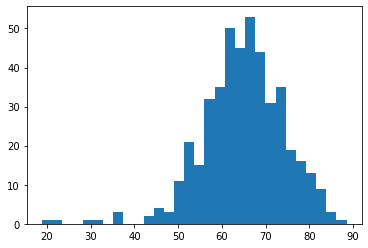

In [264]:
# check the distribution of Pct_hmowner
plt.hist(data=df_solfin, x='Pct_hmowner', bins=30);

The data are slightly left-skewed, so we'll imputed the median instead of the mean

In [265]:
# add a column with the median imputed for Pct_hmowner
df_solfin['Pct_hmowner_imp'] = df_solfin['Pct_hmowner'].fillna(value=df_solfin['Pct_hmowner'].median())
display(df_solfin.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 0 to 480
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   region_name                 481 non-null    object 
 1   state_name                  481 non-null    object 
 2   count_qualified_17          481 non-null    int64  
 3   percent_covered_17          481 non-null    float64
 4   percent_qualified_17        481 non-null    float64
 5   existing_installs_count_17  481 non-null    int64  
 6   count_qualified_21          481 non-null    float64
 7   percent_covered_21          481 non-null    float64
 8   percent_qualified_21        481 non-null    float64
 9   existing_installs_count_21  481 non-null    float64
 10  CtySt                       481 non-null    object 
 11  TotalPop                    481 non-null    int64  
 12  IncomePerCap                481 non-null    int64  
 13  StCtyID                     481 non

None

Before we start calculating data, let's make sure our quantitative fields don't have obviously erroneous values.

In [266]:
display(df_solfin.describe())

,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,TotalPop,IncomePerCap,land_area_sqmi,Pct_hmowner,Pct_hmowner_imp
count,4.810000e+02,481.000000,481.000000,481.000000,4.810000e+02,481.000000,481.000000,481.000000,4.810000e+02,481.000000,481.000000,449.000000,481.000000
mean,8.735455e+04,82.809927,77.712332,1331.469854,9.967744e+04,76.253324,83.135178,1338.933472,4.327897e+05,30136.286902,1010.390707,64.924499,64.936175
std,1.413209e+05,12.246851,10.360915,4429.021783,1.578152e+05,13.738904,8.545694,4448.907370,7.194266e+05,6716.492128,1661.193003,9.416562,9.097368
min,2.688000e+03,51.302626,28.633622,0.000000,3.249000e+03,50.360957,47.443629,0.000000,9.544000e+03,18962.000000,22.830000,18.900000,18.900000
25%,2.139400e+04,73.556107,70.444685,30.000000,2.480600e+04,65.619412,77.584150,30.000000,1.150940e+05,25666.000000,418.150000,59.900000,60.200000
50%,4.506900e+04,86.357816,77.972792,90.000000,5.085700e+04,77.716186,83.971508,90.000000,2.121610e+05,29085.000000,609.770000,65.100000,65.100000
75%,1.026660e+05,92.835972,85.251390,542.000000,1.191360e+05,88.035307,89.088118,559.000000,4.907640e+05,33127.000000,916.090000,71.300000,70.500000
max,1.753898e+06,99.913476,96.974365,47384.000000,1.985306e+06,99.284043,97.933471,47474.000000,1.010572e+07,69529.000000,20056.940000,88.500000,88.500000


None of these fields have obviously erroneous data (e.g. numbers in a percentage field outside 0-100, or negative number for quantities that must be positive). There also don't seem to be min or max values that are blatant outliers, although we'll examine that more with plots later.

Now we need to calculate the variables we'll use in the analysis

In [267]:
# calculate population density
df_solfin['PopDens'] = df_solfin['TotalPop']/df_solfin['land_area_sqmi']
df_solfin['PopDens'].describe()

count      481.000000
mean      1109.134497
std       4367.314692
min          2.599454
25%        163.077817
50%        356.318855
75%        789.902379
max      72443.144985
Name: PopDens, dtype: float64

While there is a wide range here, the values don't appear completely inaccurate (e.g. no negative or zero values) and aren't astronomically high, either.

For solar adoption, we'll calculate the % of qualified roofs that are estimate to have solar installations by Project Sunroof

In [268]:
# calculate the % adoption as # of installs per # of "qualified" roofs
df_solfin['pct_install_17'] = 100.0*df_solfin['existing_installs_count_17']/df_solfin['count_qualified_17']
df_solfin['pct_install_21'] = 100.0*df_solfin['existing_installs_count_21']/df_solfin['count_qualified_21']
display(df_solfin['pct_install_17'].describe())
display(df_solfin['pct_install_21'].describe())

count    481.000000
mean       0.878589
std        1.715222
min        0.000000
25%        0.094155
50%        0.192419
75%        0.702287
max       13.998298
Name: pct_install_17, dtype: float64

count    481.000000
mean       0.780957
std        1.581048
min        0.000000
25%        0.083745
50%        0.164321
75%        0.581400
max       13.420366
Name: pct_install_21, dtype: float64

These variables are small, but consumer solar is still rare, so they probably aren't unreasonable. There are no values outside the valid range for a percentage.

To calculate solar growth, we'll use the change in % adoption from 2017 to 2021.

In [269]:
# calculate change in % from 2017-21
df_solfin['chg_pct_install'] = df_solfin['pct_install_21'] - df_solfin['pct_install_17']
display(df_solfin['chg_pct_install'].describe())

count    481.000000
mean      -0.097632
std        0.189238
min       -1.471616
25%       -0.088439
50%       -0.021743
75%       -0.008929
max        0.119271
Name: chg_pct_install, dtype: float64

It's surprising that the numbers are so small, given all the hype about renewable energy. We'll look more into whether there is an explanation for this below.

#### Summary of the cleaning and merging process
Not much cleaning had to be done to the data. Duplicated data for 1 county with erroneous-appearing Project Sunroof data for 2021 was removed. Two counties in Alaska had to be renamed to be successfully merged with census data. The ACS data for 2019, from which homeownership data were obtained, was missing data on 32 counties in Project Sunroof. A field with these missing entries median-imputed was created. Results of using both the unimputed and the imputed home ownership data will be obtained.

#### Exploratory analyses

#### Univariate

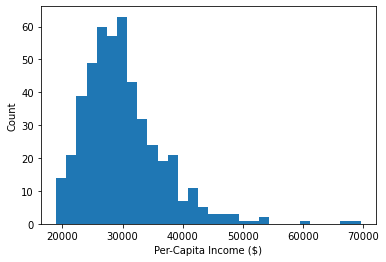

In [270]:
# per-capita income
plt.hist(data=df_solfin, x='IncomePerCap', bins=30)
plt.xlabel('Per-Capita Income ($)')
plt.ylabel('Count');

Per-capita income is right-skewed, with a peak around $30k.

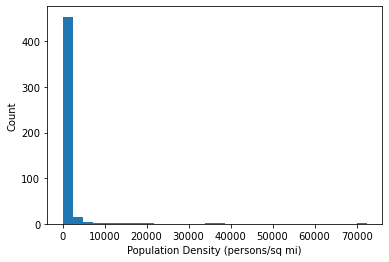

In [271]:
# population density
plt.hist(data=df_solfin, x='PopDens', bins=30)
plt.xlabel('Population Density (persons/sq mi)')
plt.ylabel('Count');

Population density is heavily right-skewed, so we'll log-transform it to make it easier to visualize

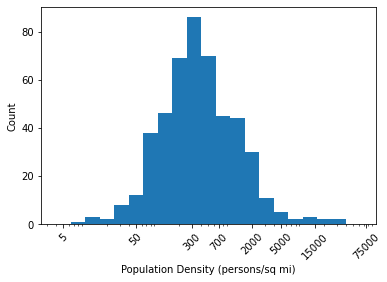

In [272]:
# severely skewed; log-transform
bins = 10**np.arange(0.6,5,0.2)
new_tix = [5, 50, 300, 700, 2000, 5000, 15000, 75000]
new_labs = ['{}'.format(v) for v in new_tix]
plt.hist(data=df_solfin, x='PopDens', bins=bins)
plt.xlabel('Population Density (persons/sq mi)')
plt.xscale('log')
plt.ylabel('Count')
plt.xticks(new_tix, new_labs, rotation=45);

Population density has a normal-appearing distribution on a log scale, with a peak around 300 persons/sq mi.

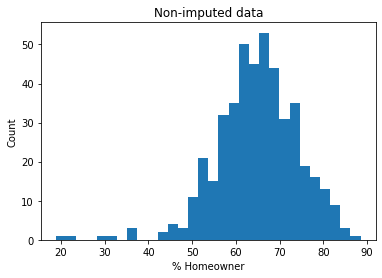

In [273]:
# percent homeowner (non-imputed)
plt.hist(data=df_solfin, x='Pct_hmowner', bins=30)
plt.xlabel('% Homeowner')
plt.ylabel('Count')
plt.title('Non-imputed data');

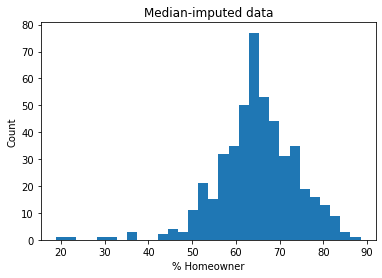

In [274]:
# percent homeowner (median-imputed)
plt.hist(data=df_solfin, x='Pct_hmowner_imp', bins=30)
plt.xlabel('% Homeowner')
plt.ylabel('Count')
plt.title('Median-imputed data');

Unimputed homeowner status is slight right-skewed with a peak between 60-70. Median-imputed homeowner status is also right skewed but now has a more pronounce peak at, surprisingly, the median value.

Since the census data for population and income are from 2017, we'll use the 2017 Project Sunroof adoption data as the outcome variable.

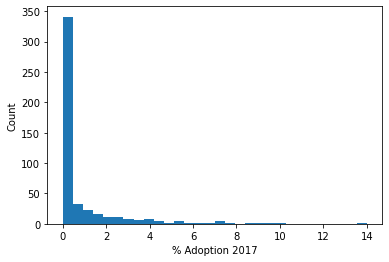

In [275]:
# outcome variable: 2017 % adoption (# installs/# qualified roofs)
plt.hist(data=df_solfin, x='pct_install_17', bins=30)
plt.xlabel('% Adoption 2017')
plt.ylabel('Count');

Percent adoption is heavily right-skewed. We'll log transform to get a better look.

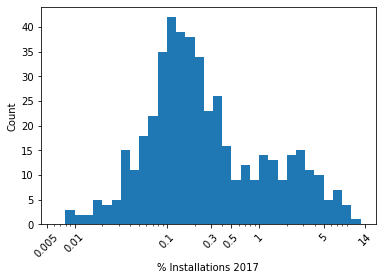

In [276]:
# severely skewed; log-transform
bins = 10**np.arange(-2.2,1.2,0.1)
new_tix = [0.005, 0.01, 0.1, 0.3, 0.5, 1, 5, 14]
new_labs = ['{}'.format(v) for v in new_tix]
plt.hist(data=df_solfin, x='pct_install_17', bins=bins)
plt.xlabel('% Installations 2017')
plt.xscale('log')
plt.ylabel('Count')
plt.xticks(new_tix, new_labs, rotation=45);

Percent adoption remains left-skewed on a log scale, with a peak around 0.2% and a long tail with several smaller peaks.

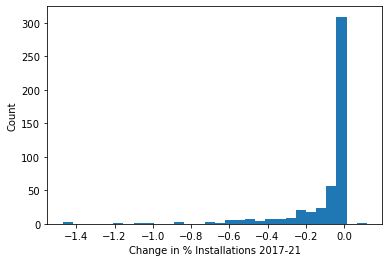

In [277]:
# change in % adoption 2017-2021
plt.hist(data=df_solfin, x='chg_pct_install', bins=30)
plt.xlabel('Change in % Installations 2017-21')
plt.ylabel('Count');

Change in adoption is heavily right skewed, with almost all the values <= 0

count    481.000000
mean      -6.556604
std       10.629263
min      -43.761307
25%      -12.946285
50%       -5.346196
75%       -1.317061
max       40.415733
Name: chg_pct_covered, dtype: float64

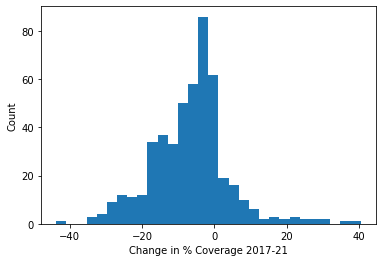

In [278]:
# the changes in adoption are tiny and mostly negative
# is this mainly because of more coverage and/or identification of more eligible roofs?
# coverage
df_solfin['chg_pct_covered'] = df_solfin['percent_covered_21'] - df_solfin['percent_covered_17']
display(df_solfin['chg_pct_covered'].describe())
plt.hist(data=df_solfin, x='chg_pct_covered', bins=30)
plt.xlabel('Change in % Coverage 2017-21')
plt.ylabel('Count');

Coverage by Project Sunroof actually tended to decrease slightly, so the small changes in adoption don't seem to be because they're covering a much larger number of roofs, but finding the same or fewer solar installations.

count       481.000000
mean      12322.891892
std       21844.289388
min       -1352.000000
25%        2762.000000
50%        5457.000000
75%       13170.000000
max      232179.000000
Name: chg_qualified, dtype: float64

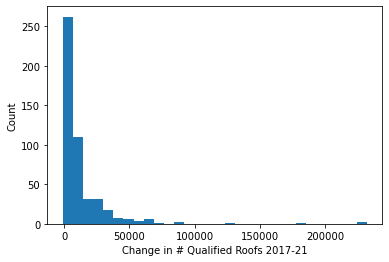

In [279]:
# did the number of qualified roofs change?
# qualified roofs
df_solfin['chg_qualified'] = df_solfin['count_qualified_21'] - df_solfin['count_qualified_17']
display(df_solfin['chg_qualified'].describe())
plt.hist(data=df_solfin, x='chg_qualified', bins=30)
plt.xlabel('Change in # Qualified Roofs 2017-21')
plt.ylabel('Count');

The number of qualified roofs did tend to increased. It's very left-skewed, so we'll log-transform for a better view.

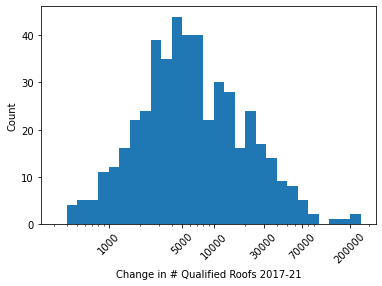

In [280]:
# log transform due to R-skewness
bins = 10**np.arange(2.5,5.5,0.1)
new_tix = [1000, 5000, 10000, 30000, 70000, 200000]
new_labs = ['{}'.format(v) for v in new_tix]
plt.hist(data=df_solfin, x='chg_qualified', bins=bins)
plt.xlabel('Change in # Qualified Roofs 2017-21')
plt.xscale('log')
plt.ylabel('Count')
plt.xticks(new_tix, new_labs, rotation=45);

On a log scale, change in qualified roofs appears nearly normal, with a peak around 5000.

Let's see if there was a large % increase.

count    481.000000
mean      20.822621
std       26.087140
min       -3.182899
25%        7.337942
50%       10.728980
75%       20.631561
max      230.858758
Name: chg_qualified_pct, dtype: float64

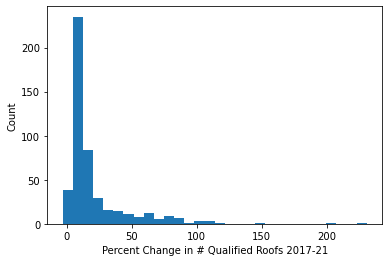

In [281]:
# qualified roofs as % of 2017 value
df_solfin['chg_qualified_pct'] = 100.0*df_solfin['chg_qualified']/df_solfin['count_qualified_17']
display(df_solfin['chg_qualified_pct'].describe())
plt.hist(data=df_solfin, x='chg_qualified_pct', bins=30)
plt.xlabel('Percent Change in # Qualified Roofs 2017-21')
plt.ylabel('Count');

There was a fairly large percentage increase, which is also right-skewed. Let's look at log-scale data.

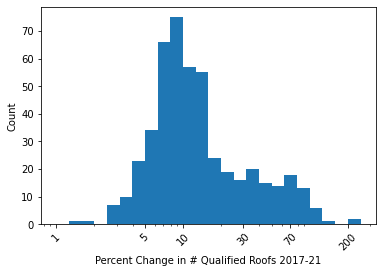

In [282]:
# log transform due to R-skewness
bins = 10**np.arange(0,2.5,0.1)
new_tix = [1, 5, 10, 30, 70, 200]
new_labs = ['{}'.format(v) for v in new_tix]
plt.hist(data=df_solfin, x='chg_qualified_pct', bins=bins)
plt.xlabel('Percent Change in # Qualified Roofs 2017-21')
plt.xscale('log')
plt.ylabel('Count')
plt.xticks(new_tix, new_labs, rotation=45);

This is still slightly right-skewed, with a peak around 9%. This may explain the decrease in adoption, since the number of qualified roofs is the denominator for adoption. 

#### Mulitvariate

These analyses compare the outcome variable (% of qualified roofs with installations, using the 2017 data) to each of the predictors.

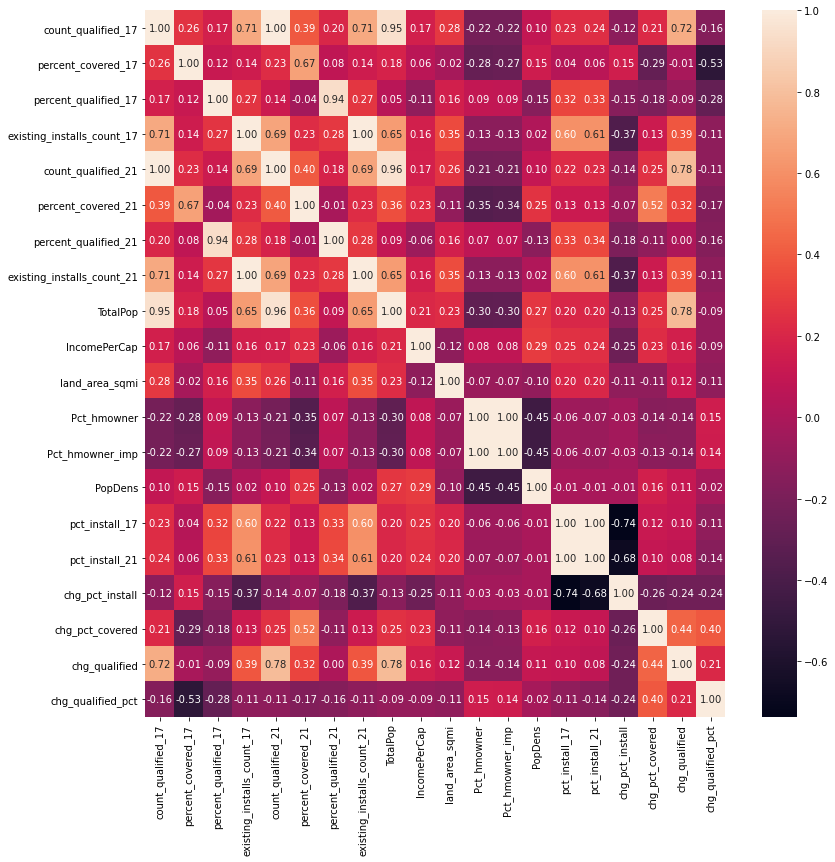

In [283]:
# get the correlation-matrix heatmap 
fig, heat = plt.subplots(figsize = (13,13))
heat = sb.heatmap(df_solfin.corr(), annot=True, fmt='.2f');

#### Question 1: Is per-capita income associated with increased solar adoption?

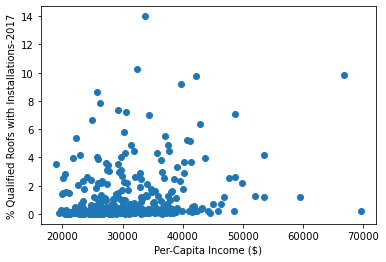

In [284]:
# first variable of interest: per-capita income
plt.scatter(data=df_solfin, x='IncomePerCap', y='pct_install_17')
plt.xlabel('Per-Capita Income ($)')
plt.ylabel('% Qualified Roofs with Installations-2017');

No clear relationship. There is no obvious indication that these are significant outliers whose removal would help the relationship.

#### Question 2: Is population density associated with increased solar adoption?

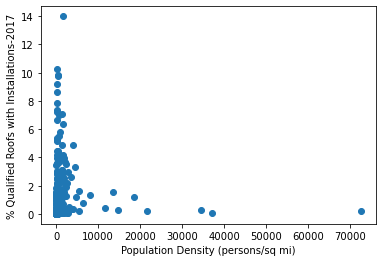

In [285]:
# second variable of interest: population density
plt.scatter(data=df_solfin, x='PopDens', y='pct_install_17')
plt.xlabel('Population Density (persons/sq mi)')
plt.ylabel('% Qualified Roofs with Installations-2017');

This is highly right-skewed, so let's see if a log transformation elucidates any kind of relationship.

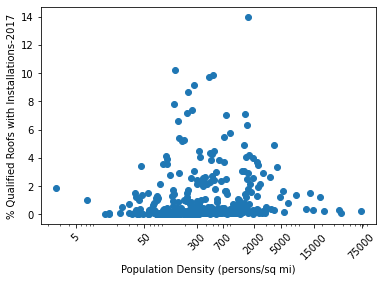

In [286]:
# redo the above with x on a log scale
new_tix = [5, 50, 300, 700, 2000, 5000, 15000, 75000]
new_labs = ['{}'.format(v) for v in new_tix]
plt.scatter(data=df_solfin, x='PopDens', y='pct_install_17')
plt.xlabel('Population Density (persons/sq mi)')
plt.ylabel('% Qualified Roofs with Installations-2017')
plt.xscale('log')
plt.xticks(new_tix, new_labs, rotation=45);

There is again no clear relationship, on a linear or log scale. The higher population densities represent heavily urban areas, so we want to keep them in the analysis. It does not appear removing them would change this weak relationship anyway.

#### Question 3: Is home ownership associated with increased solar adoption?

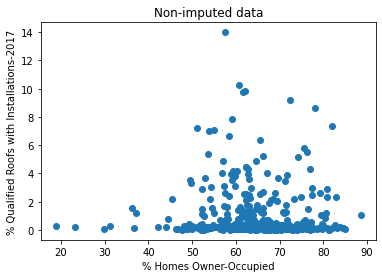

In [287]:
# third variable of interest: % homeowner (non-imputed)
plt.scatter(data=df_solfin, x='Pct_hmowner', y='pct_install_17')
plt.xlabel('% Homes Owner-Occupied')
plt.ylabel('% Qualified Roofs with Installations-2017')
plt.title('Non-imputed data');

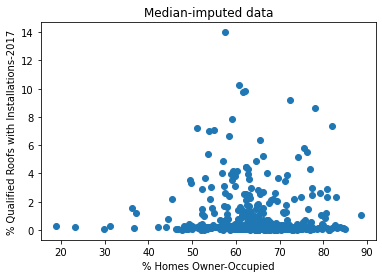

In [288]:
# third variable of interest: % homeowner (median-imputed)
plt.scatter(data=df_solfin, x='Pct_hmowner_imp', y='pct_install_17')
plt.xlabel('% Homes Owner-Occupied')
plt.ylabel('% Qualified Roofs with Installations-2017')
plt.title('Median-imputed data');

There is no clear relationship, except perhaps lower adoption at lower (< 30%) ownership rates. Again, there don't appear to be obvious outliers whose removal would impact the relationship.

#### Question 4: Which counties showed the most and least growth in solar adoption?

In [289]:
# get top ten by change in % installs (for aim 2)
pct_top10 = df_solfin.sort_values('chg_pct_install', axis=0, ascending=False).iloc[:10,:]
pct_top10

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,...,land_area_sqmi,Pct_hmowner,Pct_hmowner_imp,PopDens,pct_install_17,pct_install_21,chg_pct_install,chg_pct_covered,chg_qualified,chg_qualified_pct
4,Alameda County,California,329945,94.675889,88.489606,12126,372309.0,96.585338,94.294354,14127.0,...,739.02,53.0,53.0,2205.102704,3.675158,3.794429,0.119271,1.909450,42364.0,12.839716
432,Tuscaloosa County,Alabama,42477,91.844494,81.027412,4,41125.0,69.443791,81.999083,4.0,...,1321.76,63.3,63.3,154.660453,0.009417,0.009726,0.000310,-22.400703,-1352.0,-3.182899
124,Douglas County,Wisconsin,8474,91.179409,54.614591,0,11360.0,56.629883,71.177945,0.0,...,1304.14,NaN,65.1,33.357615,0.000000,0.000000,0.000000,-34.549526,2886.0,34.057116
44,Boyd County,Kentucky,5979,72.213898,77.538581,0,8968.0,77.716186,79.957204,0.0,...,159.86,NaN,65.1,303.302890,0.000000,0.000000,0.000000,5.502289,2989.0,49.991637
213,Jones County,Mississippi,3902,66.454534,71.860037,0,6302.0,71.708019,74.421351,0.0,...,694.80,69.3,69.3,98.341969,0.000000,0.000000,0.000000,5.253485,2400.0,61.506920
459,Wayne County,West Virginia,2975,55.240113,76.067502,0,5048.0,61.944167,81.248994,0.0,...,505.98,NaN,65.1,81.155382,0.000000,0.000000,0.000000,6.704055,2073.0,69.680672
115,Daviess County,Kentucky,12839,69.176154,77.972792,0,23924.0,73.690903,82.564881,0.0,...,458.35,67.5,67.5,216.555034,0.000000,0.000000,0.000000,4.514749,11085.0,86.338500
222,Kershaw County,South Carolina,10878,75.483376,78.934765,0,12076.0,54.904421,81.166823,0.0,...,726.56,81.4,81.4,87.720216,0.000000,0.000000,0.000000,-20.578955,1198.0,11.013054
441,Victoria County,Texas,23569,90.585693,92.188845,1,24305.0,64.692009,95.276362,1.0,...,882.14,68.7,68.7,103.745437,0.004243,0.004114,-0.000128,-25.893683,736.0,3.122746
123,Dougherty County,Georgia,23501,96.710872,75.119067,14,23640.0,95.086901,73.361470,14.0,...,328.69,46.7,46.7,278.444735,0.059572,0.059222,-0.000350,-1.623971,139.0,0.591464


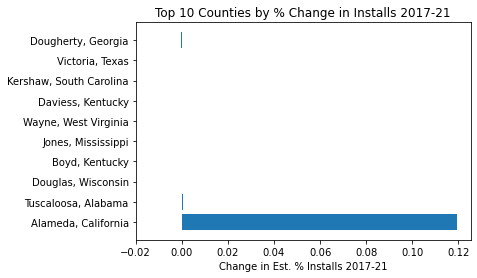

In [290]:
# look at the distribution of the top 10 by change in % adoption
plt.barh(data=pct_top10, y=np.arange(10), width='chg_pct_install', tick_label='CtySt')
plt.title('Top 10 Counties by % Change in Installs 2017-21')
plt.xlabel('Change in Est. % Installs 2017-21')
plt.xticks(np.arange(-0.02, 0.14, 0.02));

Most of the "top 10" show almost no change in installations. The largest value is only 0.12%. Kentucky has the most entries (2) in the top 10. 

In [291]:
# get bottom ten by change in % installs (for aim 2)
pct_btm10 = df_solfin.sort_values('chg_pct_install', axis=0, ascending=False).iloc[-10:,:]
pct_btm10

,region_name,state_name,count_qualified_17,percent_covered_17,percent_qualified_17,existing_installs_count_17,count_qualified_21,percent_covered_21,percent_qualified_21,existing_installs_count_21,...,land_area_sqmi,Pct_hmowner,Pct_hmowner_imp,PopDens,pct_install_17,pct_install_21,chg_pct_install,chg_pct_covered,chg_qualified,chg_qualified_pct
385,Santa Clara County,California,365304,89.384158,92.028407,25967,407240.0,91.593513,95.265944,26167.0,...,1290.10,54.9,54.9,1481.455701,7.108326,6.425449,-0.682877,2.209355,41936.0,11.479754
420,Sumter County,Florida,12029,59.129791,94.064748,124,39799.0,57.787106,97.671051,124.0,...,546.93,88.5,88.5,213.471559,1.030842,0.311566,-0.719277,-1.342685,27770.0,230.858758
232,Lake County,Florida,55672,72.911793,88.864768,1225,90288.0,63.098443,89.795918,1224.0,...,938.38,73.4,73.4,347.636352,2.200388,1.355662,-0.844726,-9.813350,34616.0,62.178474
272,Marin County,California,62120,92.918646,80.622972,6130,67983.0,87.044045,85.913054,6120.0,...,520.31,62.0,62.0,501.266553,9.867997,9.002251,-0.865747,-5.874602,5863.0,9.438184
276,Maui County,Hawaii,25736,66.025866,91.158969,2636,28060.0,63.650900,95.257494,2629.0,...,1161.52,60.8,60.8,141.275226,10.242462,9.369209,-0.873253,-2.374966,2324.0,9.030152
338,Placer County,California,97204,74.409411,89.191892,8916,111808.0,73.696802,92.120094,9141.0,...,1407.01,72.3,72.3,266.511965,9.172462,8.175622,-0.996840,-0.712609,14604.0,15.024073
186,Hernando County,Florida,29098,71.793277,90.053231,670,54906.0,67.396760,91.271174,670.0,...,472.54,80.8,80.8,379.108647,2.302564,1.220267,-1.082296,-4.396517,25808.0,88.693381
42,Boulder County,Colorado,38779,56.507248,68.277696,3783,44589.0,53.235929,77.305432,3830.0,...,726.29,61.6,61.6,436.164617,9.755280,8.589562,-1.165717,-3.271319,5810.0,14.982336
443,Volusia County,Florida,107028,69.982391,88.006315,4151,171675.0,82.886563,90.293009,4150.0,...,1101.03,71.6,71.6,471.068000,3.878424,2.417358,-1.461066,12.904172,64647.0,60.401951
285,Middlesex County,New Jersey,89845,56.448600,78.036515,2659,178638.0,96.864333,85.646068,2658.0,...,308.91,63.5,63.5,2710.459357,2.959541,1.487925,-1.471616,40.415733,88793.0,98.829095


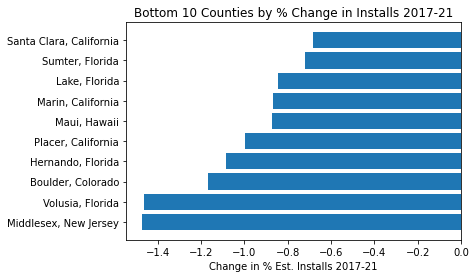

In [292]:
# plot the bottom 10
plt.barh(data=pct_btm10, y=np.arange(10,0,-1), width='chg_pct_install', tick_label='CtySt')
plt.title('Bottom 10 Counties by % Change in Installs 2017-21')
plt.xlabel('Change in % Est. Installs 2017-21');

The bottom 10 show decreases in installations of about -0.7% to -1.5%. Florida has the most entries (4) in the bottom 10. 

The significance of the negative number is unclear. Solar panels tend to last 25-30 years, so it is unlikely existing installations were removed. It may be related to how much data Project Sunroof obtained, or to its method for estimating installations. As seen above, it appears the number and percentage of qualified roofs increased from 2017 to 2021. Let's see if that has a relationship with the change in % roofs with installations.

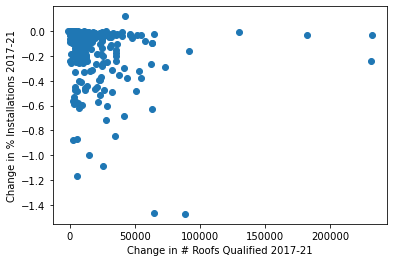

In [293]:
# visualize relationship between change in # qualified roofs and change in % installs
plt.scatter(data=df_solfin, x='chg_qualified', y='chg_pct_install')
plt.xlabel('Change in # Roofs Qualified 2017-21')
plt.ylabel('Change in % Installations 2017-21');

There is no clear relationship here. The correlation coefficient is 0.10, indicating a weak positive relationship. This is the opposite of what we'd expect and is probably artifactual due to the scatter in the data at lower x-values.

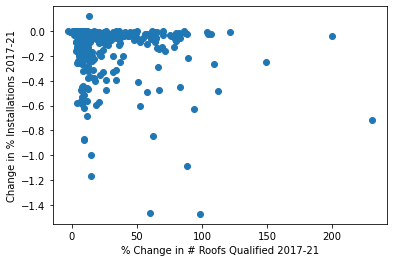

In [294]:
# visualize relationship between % change in qualified roofs and change in % installs
plt.scatter(data=df_solfin, x='chg_qualified_pct', y='chg_pct_install')
plt.xlabel('% Change in # Roofs Qualified 2017-21')
plt.ylabel('Change in % Installations 2017-21');

There may be a slight negative trend here, although there is again no clear relationship. The correlation coefficient is -0.11, indicating a weak positive relationship, which is more in line with what we'd expect (more qualified roofs leading to a lower % of installations if more panels aren't identified).

## Modeling

There doesn't appear to be a strong relationship between any of the variables of interest and prevalence of solar installations, but will verify by attempting to fit a multivariate linear regression.

#### Model 1: Using non-imputed home ownership data

In [295]:
#Split into explanatory and response variables
X = df_solfin[~df_solfin['Pct_hmowner'].isnull()][['IncomePerCap', 'PopDens', 'Pct_hmowner']]
y = df_solfin[~df_solfin['Pct_hmowner'].isnull()]['pct_install_17']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
r2_test = lm_model.score(X_test, y_test) 
"The r-squared score for your model was {} on {} values.".format(r2_test, len(y_test))

'The r-squared score for your model was -0.12233636313826435 on 135 values.'

#### Model 2: Using median-imputed home ownership data

In [296]:
#Split into explanatory and response variables
X = df_solfin[['IncomePerCap', 'PopDens', 'Pct_hmowner_imp']]
y = df_solfin['pct_install_17']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
r2_test = lm_model.score(X_test, y_test) 
"The r-squared score for your model was {} on {} values.".format(r2_test, len(y_test))

'The r-squared score for your model was 0.028582350506633825 on 145 values.'

The imputed dataset gives slightly better performance, from no explanatory power to very slight. This is probably not a practically significant difference.

## Results

#### Question 1: Is per-capita income associated with increased solar adoption?

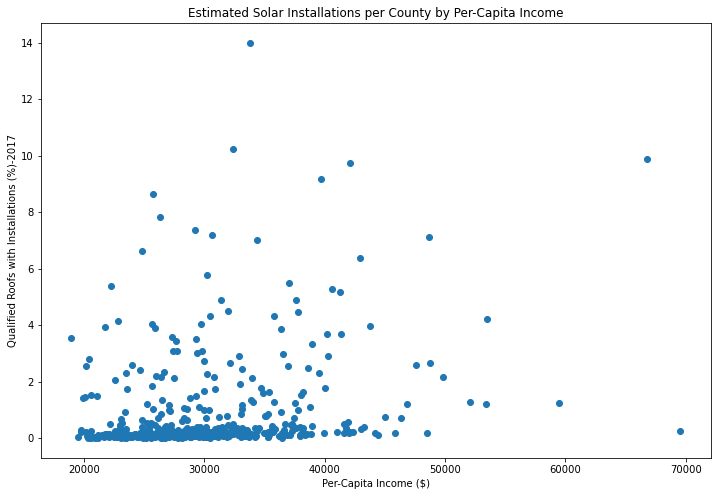

In [297]:
fig1, scat1 = plt.subplots(figsize = (12,8))
scat1 = plt.scatter(data=df_solfin, x='IncomePerCap', y='pct_install_17')
plt.xlabel('Per-Capita Income ($)')
plt.ylabel('Qualified Roofs with Installations (%)-2017')
plt.title('Estimated Solar Installations per County by Per-Capita Income');

The correlation coefficient for these two variables is 0.25, indicating a weak positive relationship. The scatter plot shows a slightly linear relationship, influenced by a few points at higher income levels. 

#### Question 2: Is population density associated with increased solar adoption?

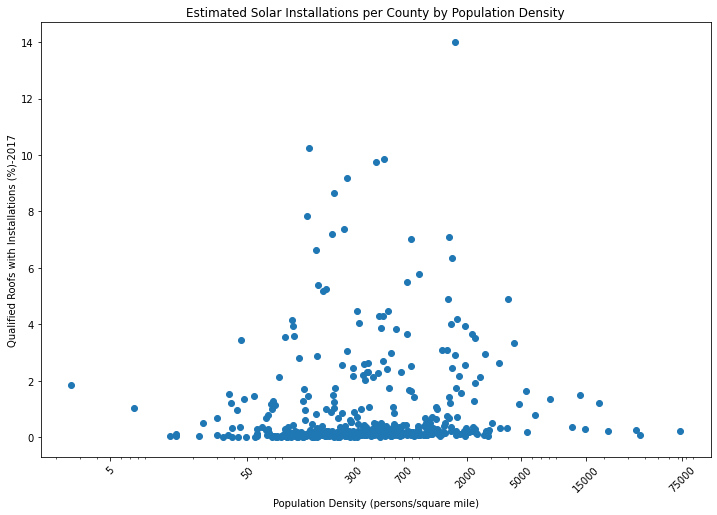

In [298]:
fig2, scat2 = plt.subplots(figsize = (12,8))
scat2 = plt.scatter(data=df_solfin, x='PopDens', y='pct_install_17')
new_tix = [5, 50, 300, 700, 2000, 5000, 15000, 75000]
new_labs = ['{}'.format(v) for v in new_tix]
plt.xlabel('Population Density (persons/square mile)')
plt.ylabel('Qualified Roofs with Installations (%)-2017')
plt.xscale('log')
plt.xticks(new_tix, new_labs, rotation=45);
plt.title('Estimated Solar Installations per County by Population Density');

The correlation between these two variables -0.01, indicating a very weak negative relationship. Transforming the right-skewed data to a  logarithmic scale (as shown above) does not reveal a clear relationship. There is a peak at moderate population densities, but most of the data are clustered around the lowest adoption rates.

#### Question 3: Is home ownership associated with increased solar adoption?

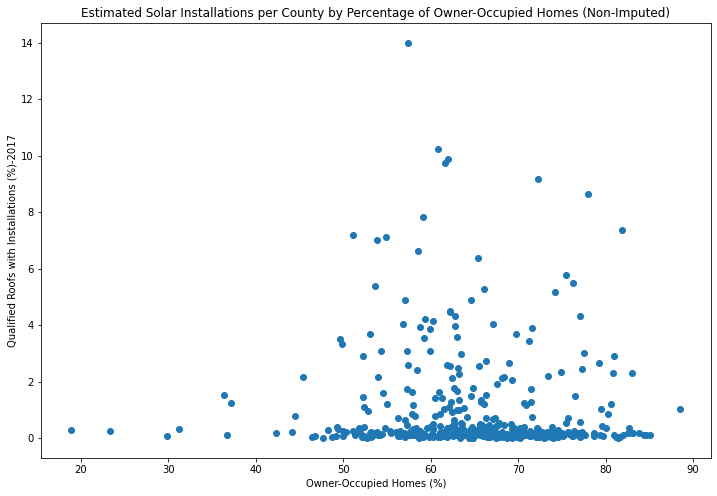

In [299]:
# third variable of interest: % homeowner (non-imputed)
fig3, scat3 = plt.subplots(figsize = (12,8))
scat3 = plt.scatter(data=df_solfin, x='Pct_hmowner', y='pct_install_17')
plt.xlabel('Owner-Occupied Homes (%)')
plt.ylabel('Qualified Roofs with Installations (%)-2017')
plt.title('Estimated Solar Installations per County by Percentage of Owner-Occupied Homes (Non-Imputed)');

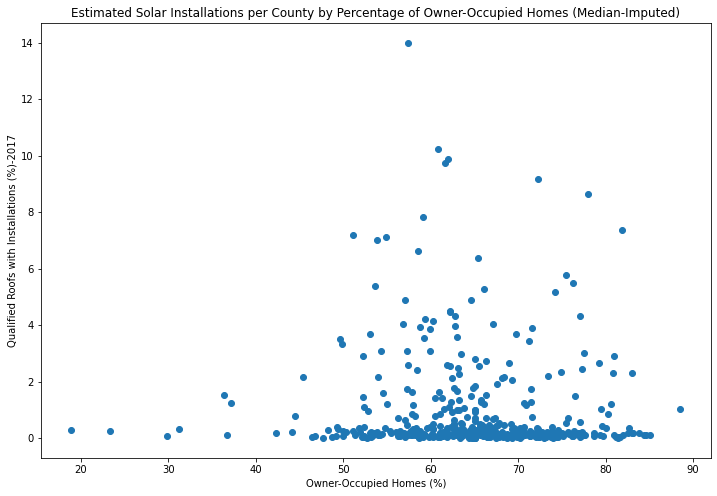

In [300]:
# third variable of interest: % homeowner (median-imputed)
fig4, scat4 = plt.subplots(figsize = (12,8))
scat4 = plt.scatter(data=df_solfin, x='Pct_hmowner_imp', y='pct_install_17')
plt.xlabel('Owner-Occupied Homes (%)')
plt.ylabel('Qualified Roofs with Installations (%)-2017')
plt.title('Estimated Solar Installations per County by Percentage of Owner-Occupied Homes (Median-Imputed)');

The correlation between these two variables was -0.06, regardless of whether non-imputed or imputed data were used. While there does seem to be an association of lower solar adoption with lower prevalence of home ownership (< 30%), the bulk of the data are heavily scattered, similar to those for population density. Like the correlation coefficient, the visual relationship is unchanged by the presence of the imputed data. 

#### Multivariate model

The linear regression model, with percentage of qualified roofs with installations as the dependent variable and per-capita income, population density, and home ownsership as the independent variables, did not show strong explanatory power when assessed on a test dataset comprised of 30% of the data. The model without imputed home ownership (N = 135 training values) had an R-squared of -0.12, indicating no explanatory value. The model using the median-imputed home ownership data (N = 145 training values) was slightly better, with an R-squared of 0.03. This probably has no practical significance, as the latter model still has very little explanatory power.

#### Question 4: Which counties showed the most and least growth in solar adoption?

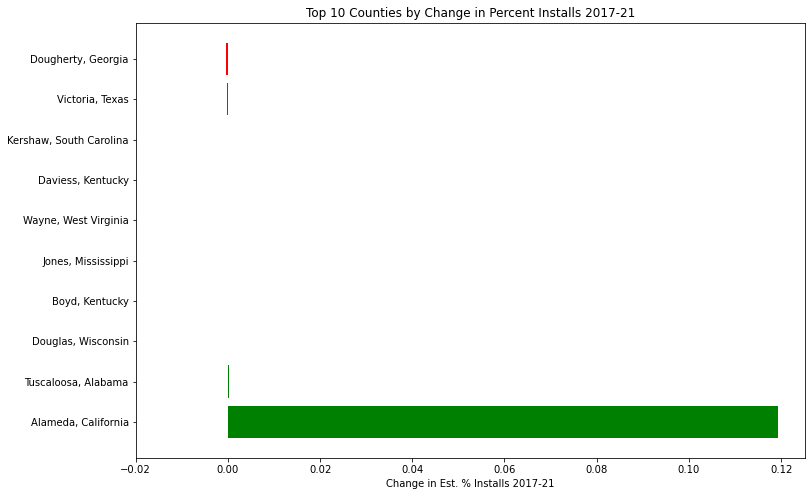

In [301]:
fig5, bar1 = plt.subplots(figsize = (12,8))
pct_top10['negpos'] = pct_top10['chg_pct_install'] < 0
bar1 = plt.barh(data=pct_top10, y=np.arange(10), width='chg_pct_install', tick_label='CtySt',\
               color=pct_top10['negpos'].map({True:'r', False:'g'}))
plt.title('Top 10 Counties by Change in Percent Installs 2017-21')
plt.xlabel('Change in Est. % Installs 2017-21')
plt.xticks(np.arange(-0.02, 0.14, 0.02));

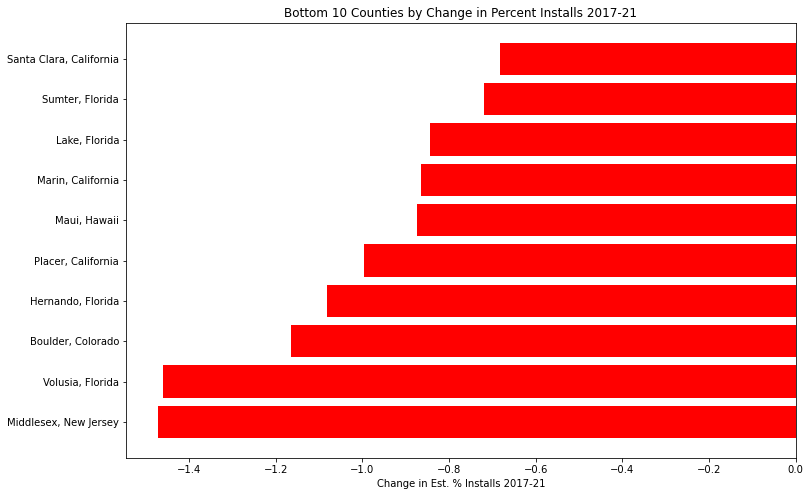

In [302]:
fig6, bar2 = plt.subplots(figsize = (12,8))
pct_btm10['negpos'] = pct_btm10['chg_pct_install'] < 0
bar1 = plt.barh(data=pct_btm10, y=np.arange(10,0,-1), width='chg_pct_install', tick_label='CtySt',\
               color=pct_btm10['negpos'].map({True:'r', False:'g'}))
plt.title('Bottom 10 Counties by Change in Percent Installs 2017-21')
plt.xlabel('Change in Est. % Installs 2017-21');

The Project Sunroof data showed very modest changes from 2017 to 2021 in the percentage of eligible roofs estimated to have solar installations. The median and interquartile range for the difference in percentages was -0.02% [-0.1%, -0.01%]. Of the top 10 counties, only two showed increased installation prevalence, and the maximum value was 0.12%. The bottom 10 counties showed changes ranging from -0.7% to -1.5%. Kentucky had the most counties (2) in the top 10, while Florida had the most (4) in the bottom 10.

It is possible the decline in installation prevalence could be due to Project Sunroof having data available on more homes in 2021. However, for the counties analyzed, the median and interquartile range for change in percent of Google Maps coverage from 2017 to 2021 was actually negative: -5.3% [-12.9%, -1.3%].

Another possibility might be that more houses are being deemed solar-qualified by Google's algorithm. This did seem to be the case: the median and interquartile range for percent change in number of qualified roofs from 2017 to 2021 was 10.7% [7.3%, 20.6%]. However, when this variable was plotted against the change in percentage of roofs estimated to have installations, there was only a weak negative trend (correlation coefficient -0.24), as shown below.

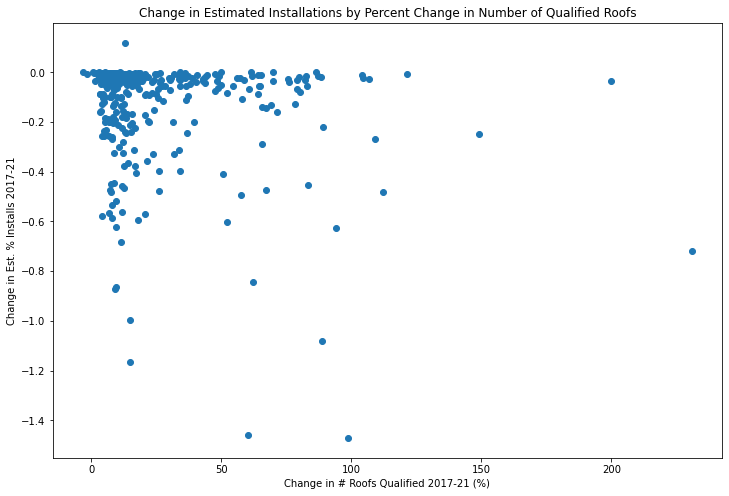

In [303]:
# visualize relationship between % change in qualified roofs and change in % installs
fig7, scat5 = plt.subplots(figsize = (12,8))
scat5 = plt.scatter(data=df_solfin, x='chg_qualified_pct', y='chg_pct_install')
plt.xlabel('Change in # Roofs Qualified 2017-21 (%)')
plt.ylabel('Change in Est. % Installs 2017-21')
plt.title('Change in Estimated Installations by Percent Change in Number of Qualified Roofs');

## Deployment

This analysis did not show a clear relationship between the selected demographic variables (per-capita income, population density, and home ownership) and the percentage of solar-qualified homes estimated to have solar installations by Google Project Sunroof. There was a very slight improvement in the model a slightly larger dataset, with home ownership median-imputed. However, this change did not meaningfully alter the conclusions.

This may have been due to the low prevalence of solar installations identified (median 0.2% of qualified roofs) making it hard to clearly define a relationship. It is also possible that other variables, such as state or local incentives (e.g., tax credits and availability of net metering), zoning or homeowner association restrictions, and availability of solar installers and maintainers could have a larger influence than demographics. These variables were not captured in the dataset and would be appropriate subjects for further analysis.

Additionally, the data may not be an adequate or representative sample. The data cover 481 counties (449 without imputing home ownership) in 49 states, out of 3142 counties in the 2017 Census data. Only counties with at least 50% of their Google Maps data included in Project Sunroof were included. This may bias the data toward areas where Google was more easily able, or more motivated, to collect aerial footage and to analyze it via Project Sunroof.

Furthermore, it is possible that Project Sunroof is not accurately estimating the number of installations. According to the [methodology](https://www.google.com/get/sunroof/data-explorer/data-explorer-methodology.pdf), installations are estimated by a machine-learning algorithm which was trained on human-labeled images of roofs. They admit that this approach is limited by the paucity of imagery of solar installations available. No data are provided on the accuracy of the algorithm, or any effort to validate it, e.g. with sales data from solar panel installers.

The analysis of growth in solar adoption using 2021 versus 2017 data showed very little change in the percentage of solar-eligible roofs estimated to have solar installations. In fact, most of the data showed no change or a slight decrease. A decrease in installations due to their removal is unlikely, as good-quality solar panels can last 25-30 years. [Solar energy industry data](https://www.seia.org/solar-industry-research-data) also indicate a steady rise in residential installations between 2017 and 2021. However, the latter data indicate total residential installations in the 2000-3000 homes/year range for that period, representing a very small percentage of homes. Additionally, the accuracy of these numbers depends on the machine-learning algorithm used to identify solar installations, whose accuracy, as discussed above, is unknown.

In summary, this analysis was unable to identify a relationship between the studied demographic variables and solar adoption for selected US counties. Other explanatory variables may wield heavier influence. Estimating growth in solar adoption using the Project Sunroof data showed almost no increase in installations as a percentage of roofs identified as eligible. Multiple limitations in the data collection methodology may explain these findings, and further study is warranted.

#### wrap-up

In [304]:
# save the final data
df_solfin.to_csv('solar_final.csv')

In [305]:
df_solfin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481 entries, 0 to 480
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   region_name                 481 non-null    object 
 1   state_name                  481 non-null    object 
 2   count_qualified_17          481 non-null    int64  
 3   percent_covered_17          481 non-null    float64
 4   percent_qualified_17        481 non-null    float64
 5   existing_installs_count_17  481 non-null    int64  
 6   count_qualified_21          481 non-null    float64
 7   percent_covered_21          481 non-null    float64
 8   percent_qualified_21        481 non-null    float64
 9   existing_installs_count_21  481 non-null    float64
 10  CtySt                       481 non-null    object 
 11  TotalPop                    481 non-null    int64  
 12  IncomePerCap                481 non-null    int64  
 13  StCtyID                     481 non